<a href="https://colab.research.google.com/github/abhinavkk/Consistent-Adversarial-Training/blob/main/RobustAdversarialTrainedClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%tensorflow_version 1.x
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
!pip install cleverhans==2.1.0

TensorFlow 1.x selected.
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 42 kB 971 kB/s 
     |████████████████████████████████| 154 kB 18.0 MB/s 


In [ ]:
!pip install 'h5py==2.10.0'

     |████████████████████████████████| 2.9 MB 9.7 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
#Import necessary packages
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend
from tensorflow.keras.utils import to_categorical
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2
import json
import torchvision
import torch
import gc
import pickle

Using TensorFlow backend.


In [ ]:
# ### Saving Checkpoints and Loading for Training

# model_path = '/content/gdrive/MyDrive/Spring2022/ECE595ML/TermProject/trained_model'

# # Save the model
# def save_model(model, epsilon, epochs):
#   model.save(model_path + f'/epsilon_{str(epsilon)}_{str(epochs)}')
#   # data = {
#   #     'losses':losses,
#   # }
#   # with open(model_path + '/epsilon_{}_metadata.json'.format(str(epsilon)), 'w') as file:
#   #   json.dump(data, file, indent=2)

# # Load model
# def load_model(epsilon, epochs):
#   model = keras.models.load_model(model_path + f'/epsilon_{str(epsilon)}_{str(epochs)}')
#   # model.load_state_dict(torch.load(model_path + '/epsilon_{}'.format(str(epsilon))))
#   return model

# # Get model metadata
# def get_model_metadata(epsilon):
#   with open(model_path + '/epsilon_{}_metadata.json'.format(str(epsilon)), 'r') as file:
#     return json.load(file)

In [ ]:
# Load data MNIST data and normalize to [0, 1]
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = data_train/255.0
data_test = data_test/255.0

#Reshape training and testing data into 784-dimensional vectors 
data_train = data_train.reshape(-1, 784)
data_test = data_test.reshape(-1, 784)

#Convert integer labels for training and testing data into one-hot vectors 
labels_train = to_categorical(labels_train)
labels_test = to_categorical(labels_test)

#Create classifier architecture
def fc_classifier():
  model = Sequential()
  model.add(Dense(100, input_dim=784, activation='relu', kernel_initializer='uniform'))
  model.add(BatchNormalization())
  model.add(Dense(100, activation='relu', kernel_initializer='uniform'))
  model.add(BatchNormalization())
  model.add(Dense(10, activation='softmax', kernel_initializer='uniform'))
  return model

11493376/11490434 [==============================] - 1s 0us/step


In [ ]:
### Saving Checkpoints and Loading for Training

model_path = '/content/gdrive/MyDrive/Spring2022/ECE595ML/TermProject/trained_model'

# Save the model
def save_model(model, epsilon, epochs):
  model.save_weights(model_path + f'/epsilon_{str(epsilon)}_{str(epochs)}_weights.h5')
  symbolic_weights = getattr(model.optimizer, 'weights')
  weight_values = backend.batch_get_value(symbolic_weights)
  with open(model_path + f'/epsilon_{str(epsilon)}_{str(epochs)}_optimizer.pkl', 'wb') as f:
    pickle.dump(weight_values, f)

# Load model
def load_model(epsilon, epochs):
  model = fc_classifier()
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.load_weights(model_path + f'/epsilon_{str(epsilon)}_{str(epochs)}_weights.h5')
  model._make_train_function()
  with open(model_path + f'/epsilon_{str(epsilon)}_{str(epochs)}_optimizer.pkl', 'rb') as f:
    weight_values = pickle.load(f)
  model.optimizer.set_weights(weight_values)
  return model

# Get model metadata
def get_model_metadata(epsilon):
  with open(model_path + '/epsilon_{}_metadata.json'.format(str(epsilon)), 'r') as file:
    return json.load(file)

In [ ]:
#Create classifier and train it
classifier = fc_classifier()
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier_metadata = classifier.fit(data_train, labels_train,
                                     validation_data=(data_test, labels_test),
                                     epochs=40,
                                     batch_size=256,
                                     shuffle=True)

scores = classifier.evaluate(data_test, labels_test)
print(f'Testing accuracy of our original Model {scores[1]*100}%')

#Save model
save_model(classifier, 0, 40)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 3s 47us/step - loss: 0.3284 - accuracy: 0.9217 - val_loss: 0.4300 - val_accuracy: 0.9616
Epoch 2/40
60000/60000 [==============================] - 1s 20us/step - loss: 0.0977 - accuracy: 0.9705 - val_loss: 0.1050 - val_accuracy: 0.9678
Epoch 3/40
60000/60000 [==============================] - 1s 20us/step - loss: 0.0637 - accuracy: 0.9814 - val_loss: 0.0786 - val_accuracy: 0.9765
Epoch 4/40
60000/60000 [==============================] - 1s 20us/step - loss: 0.0471 - accuracy: 0.9860 - val_loss: 0.0886 - val_accuracy: 0.9727
Epoch 5/40
60000/60000 [==============================] - 1s 20us/step - loss: 0.0359 - accuracy: 0.9889 - val_loss: 0.0841 - val_accuracy: 0.9761
Epoch 6/40
60000/60000 [==============================] - 1s 20us/step - loss: 0.0286 - accuracy: 0.9912 - val_loss: 0.0839 - val_acc

In [ ]:
#Load our original trained classifier
test = load_model(0, 50)
scores_test = test.evaluate(data_test, labels_test)
print(f'Testing accuracy of our original Model {scores_test[1]*100}%')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

10000/10000 [==============================] - 1s 135us/step
Testing accuracy of our original Model 97.69999980926514%


In [ ]:
# Edit the classifier name fed into KerasModel Wrapper with the name of the 
# classifier from above and then run this block

#Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
classifier = load_model(0, 50)
wrap = KerasModelWrapper(classifier)

In [ ]:
epsilon = np.arange(0.1, 0.6, 0.025)
epsilon=np.insert(epsilon, 0, [0.0, 0.5])
print(epsilon)


[0.    0.5   0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325
 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575]


In [ ]:
print(epsilon)

[0.    0.5   0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325
 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575]


In [ ]:
#Implementing the FGSM attack

#FGM Instance on trained classifier from Part 1
fast_gradient_method = FastGradientMethod(wrap, sess=sess)
epsilon = np.arange(0.1, 0.6, 0.025)
epsilon = np.insert(epsilon, 0, [0.0, 0.05])
fgm_scores = []
fgm_attack_data_train = []
fgm_attack_data_test = []

for e in epsilon:
  #Attack parameters
  fgm_params = {'eps':e,
              'clip_min':0.,
              'clip_max':1.}
  #Generate adversarial data
  data_train_ad = fast_gradient_method.generate_np(data_train, **fgm_params)
  data_test_ad = fast_gradient_method.generate_np(data_test, **fgm_params)
  fgm_attack_data_train.append(data_train_ad)
  fgm_attack_data_test.append(data_test_ad)
  # print(f'e: {e} score: {classifier.evaluate(data_test_ad, labels_test)[1]*100}')
  fgm_scores.append(classifier.evaluate(data_test_ad, labels_test)[1]*100)



Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

10000/10000 [==============================] - 0s 44us/step


Text(0.5, 1.0, 'Classfier Accuracy vs FGSM Attack Strength')

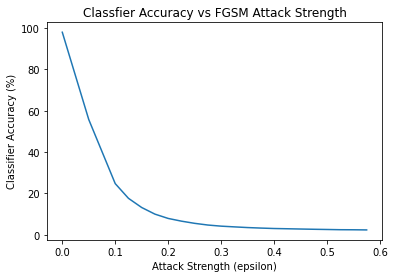

In [ ]:
plt.plot(epsilon, fgm_scores)
plt.xlabel('Attack Strength (epsilon)')
plt.ylabel('Classifier Accuracy (%)')
plt.title('Classfier Accuracy vs FGSM Attack Strength')

In [ ]:
#Train classifiers with different FGM attack strength
adversarial_trained_classifiers = []
adversarial_trained_classifiers_scores = []
# adversarial_trained_classifiers_metadata = []
# epochs = np.arange(40, 135, 5)
epochs = np.tile(40, epsilon.size)

for i in range(0, epsilon.size):
  temp_classifier = fc_classifier()
  temp_classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(f'Training model with epsilon: {epsilon[i]}')
  
  temp_classifier_metadata = temp_classifier.fit(fgm_attack_data_train[i], labels_train,
                                     validation_data=(fgm_attack_data_test[i], labels_test),
                                     epochs=epochs[i],
                                     batch_size=256,
                                     shuffle=True)
  temp_scores = temp_classifier.evaluate(fgm_attack_data_test[i], labels_test)
  print(f'Accuracy before training: {fgm_scores[i]} and Accuracy after training: {temp_scores[1]*100}')

  adversarial_trained_classifiers.append(temp_classifier)
  adversarial_trained_classifiers_scores.append(temp_scores[1]*100)
  # adversarial_trained_classifiers_metadata.append(temp_classifier_metadata)
  save_model(temp_classifier, i, epochs[i])
  gc.collect()


Training model with epsilon: 0.0
Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 1s 25us/step - loss: 0.3313 - accuracy: 0.9201 - val_loss: 0.4886 - val_accuracy: 0.9559
Epoch 2/40
60000/60000 [==============================] - 1s 19us/step - loss: 0.0980 - accuracy: 0.9710 - val_loss: 0.1029 - val_accuracy: 0.9693
Epoch 3/40
60000/60000 [==============================] - 1s 19us/step - loss: 0.0662 - accuracy: 0.9796 - val_loss: 0.0870 - val_accuracy: 0.9730
Epoch 4/40
60000/60000 [==============================] - 1s 19us/step - loss: 0.0477 - accuracy: 0.9851 - val_loss: 0.0810 - val_accuracy: 0.9751
Epoch 5/40
60000/60000 [==============================] - 1s 19us/step - loss: 0.0374 - accuracy: 0.9883 - val_loss: 0.0832 - val_accuracy: 0.9759
Epoch 6/40
60000/60000 [==============================] - 1s 19us/step - loss: 0.0285 - accuracy: 0.9912 - val_loss: 0.0867 - val_accuracy: 0.9740
Epoch 7/40
60000/60000 [===========

In [ ]:
#Create pi_p (uniform distribution of attach strength dataset)
uniform_fgm_attack_data_train = np.array([]).reshape(0, 784)
uniform_labels_train = np.array([]).reshape(0, 10)
uniform_fgm_attack_data_test = np.array([]).reshape(0, 784)

for i in range(0, epsilon.size):
  print(f'Generating data from epsilon: {epsilon[i]}')
  random_idx = np.random.choice(60000, 10000)
  uniform_fgm_attack_data_train = np.concatenate((uniform_fgm_attack_data_train, fgm_attack_data_train[i][random_idx]))
  uniform_labels_train = np.concatenate((uniform_labels_train, labels_train[random_idx]))
  uniform_fgm_attack_data_test = np.concatenate((uniform_fgm_attack_data_test, fgm_attack_data_test[i]))

uniform_labels_test = np.tile(labels_test, (epsilon.size, 1))

Generating data from epsilon: 0.0
Generating data from epsilon: 0.05
Generating data from epsilon: 0.1
Generating data from epsilon: 0.125
Generating data from epsilon: 0.15
Generating data from epsilon: 0.175
Generating data from epsilon: 0.19999999999999998
Generating data from epsilon: 0.22499999999999998
Generating data from epsilon: 0.24999999999999997
Generating data from epsilon: 0.27499999999999997
Generating data from epsilon: 0.29999999999999993
Generating data from epsilon: 0.32499999999999996
Generating data from epsilon: 0.35
Generating data from epsilon: 0.3749999999999999
Generating data from epsilon: 0.3999999999999999
Generating data from epsilon: 0.42499999999999993
Generating data from epsilon: 0.44999999999999996
Generating data from epsilon: 0.47499999999999987
Generating data from epsilon: 0.4999999999999999
Generating data from epsilon: 0.5249999999999999
Generating data from epsilon: 0.5499999999999999
Generating data from epsilon: 0.5749999999999998


In [ ]:
print(uniform_fgm_attack_data_train.shape)
print(uniform_labels_train.shape)
print(uniform_fgm_attack_data_test.shape)
print(uniform_labels_test.shape)

(220000, 784)
(220000, 10)
(220000, 784)
(220000, 10)


In [ ]:
# Train Uniform classifier
uniform_classifier = fc_classifier()
uniform_classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
uniform_classifier_metadata = uniform_classifier.fit(uniform_fgm_attack_data_train, uniform_labels_train,
                                     validation_data=(uniform_fgm_attack_data_test, uniform_labels_test),
                                     epochs=40,
                                     batch_size=256,
                                     shuffle=True)
uniform_classifier_scores = uniform_classifier.evaluate(uniform_fgm_attack_data_test, uniform_labels_test)
print(f'Accuracy after training with uniform distribution of perturbed data: {uniform_classifier_scores[1]*100}')

#Save trained uniform classifier
save_model(uniform_classifier, 'uniform', 40)

Train on 220000 samples, validate on 220000 samples
Epoch 1/40
220000/220000 [==============================] - 8s 38us/step - loss: 0.1235 - accuracy: 0.9700 - val_loss: 0.2033 - val_accuracy: 0.9655
Epoch 2/40
220000/220000 [==============================] - 7s 33us/step - loss: 0.0290 - accuracy: 0.9916 - val_loss: 0.2149 - val_accuracy: 0.9664
Epoch 3/40
220000/220000 [==============================] - 7s 33us/step - loss: 0.0191 - accuracy: 0.9943 - val_loss: 0.2517 - val_accuracy: 0.9661
Epoch 4/40
220000/220000 [==============================] - 7s 33us/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.2569 - val_accuracy: 0.9709
Epoch 5/40
220000/220000 [==============================] - 7s 33us/step - loss: 0.0120 - accuracy: 0.9962 - val_loss: 0.2463 - val_accuracy: 0.9704
Epoch 6/40
220000/220000 [==============================] - 7s 33us/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 0.2647 - val_accuracy: 0.9699
Epoch 7/40
220000/220000 [============================

In [ ]:
#Load trained uniform classifier
# uniform_classifier = load_model('uniform', 40)

#Test uniform classifier and independent adversarial strength classifier with different strength fgm attack data
uniform_classifier_independent_scores = []
adversarial_trained_classifiers_scores = []
epochs = np.tile(40, epsilon.size)

for i in range(0, epsilon.size):
  # independent_model = load_model(i, epochs[i])
  independent_model = adversarial_trained_classifiers[i]
  adversarial_trained_classifiers_scores.append(independent_model.evaluate(fgm_attack_data_test[i], labels_test)[1]*100)
  uniform_classifier_independent_scores.append(uniform_classifier.evaluate(fgm_attack_data_test[i], labels_test)[1]*100)

10000/10000 [==============================] - 1s 66us/step


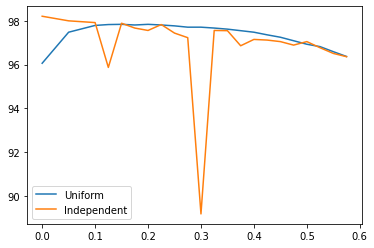

In [ ]:
plt.plot(epsilon, uniform_classifier_independent_scores)
plt.plot(epsilon, adversarial_trained_classifiers_scores)
plt.legend(['Uniform', 'Independent'])

In [ ]:
print(np.max(-np.array(adversarial_trained_classifiers_scores) + np.array(uniform_classifier_independent_scores)))

54.16000187397003


In [ ]:
#Implement Dual Ascent Algorithm and Train Dual Ascent Classfier
p = np.ones(epsilon.size)
lambd = np.zeros(epsilon.size)
tot_epoch = 50
alpha = 0.01
e = 4

dual_ascent_classifier = fc_classifier()
dual_ascent_classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

for i in range(tot_epoch):
  print(f'>>>>>>>>>>> DUAL ASCENT ALGORITHM EPOCH: {i+1}/{tot_epoch}<<<<<<<<<<<')

  #Generate distribution for the epoch
  distribution = p+lambd
  distribution = distribution*(epsilon.size)/np.sum(distribution)
  print(f'Training with distribution: {distribution}')

  #Generate data for the epoch
  epoch_data_train = np.array([]).reshape(0, 784)
  epoch_labels_train = np.array([]).reshape(0, 10)
  epoch_data_test = np.array([]).reshape(0, 784)
  epoch_labels_test =  np.array([]).reshape(0, 10)

  for j in range(0, epsilon.size):
    random_idx = np.random.choice(60000, int(10000*distribution[j]))
    epoch_data_train = np.concatenate((epoch_data_train, fgm_attack_data_train[j][random_idx]))
    epoch_labels_train = np.concatenate((epoch_labels_train, labels_train[random_idx]))

    random_idx_test = np.random.choice(10000, int(1500*distribution[j]))
    epoch_data_test = np.concatenate((epoch_data_test, fgm_attack_data_test[j][random_idx_test]))
    epoch_labels_test = np.concatenate((epoch_labels_test, labels_test[random_idx_test]))

  #Train the classifier for the epoch distribution
  dual_ascent_classifier.fit(epoch_data_train, epoch_labels_train,
                                     validation_data=(epoch_data_test, epoch_labels_test),
                                     epochs=1,
                                     batch_size=256,
                                     shuffle=True)
  
  #Update lambda
  print(f'Computing lambda')
  independent_strength_scores = []
  for j in range(0, epsilon.size):
    epoch_independent_strength_score = dual_ascent_classifier.evaluate(fgm_attack_data_test[j], labels_test)[1]*100
    lambd[j] = max(0, lambd[j] + alpha*(100-epoch_independent_strength_score-e))
    independent_strength_scores.append(epoch_independent_strength_score)
  print(f'Scores for independent attack strength: {independent_strength_scores}')
  print(f'Updated lambda: {lambd}')
  gc.collect()

#Save Dual Ascent Classifier
save_model(dual_ascent_classifier, 'dual', 50)

>>>>>>>>>>> DUAL ASCENT ALGORITHM EPOCH: 1/50<<<<<<<<<<<
Training with distribution: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Train on 320000 samples, validate on 48000 samples
Epoch 1/1
320000/320000 [==============================] - 14s 45us/step - loss: 1.3381 - accuracy: 0.5204 - val_loss: 1.3417 - val_accuracy: 0.5291
Computing lambda
10000/10000 [==============================] - 0s 43us/step
Scores for independent attack strength: [94.9400007724762, 94.66999769210815, 94.69000101089478, 93.83999705314636, 92.28000044822693, 87.99999952316284, 79.1100025177002, 62.80999779701233, 43.61000061035156, 27.84000039100647, 17.980000376701355, 13.969999551773071, 11.879999935626984, 11.330000311136246, 10.480000078678131, 10.300000011920929]
Updated lambda: [0.01059999 0.01330002 0.01309999 0.02160003 0.0372     0.08
 0.16889997 0.33190002 0.52389999 0.6816     0.7802     0.8203
 0.8412     0.8467     0.8552     0.857     ]
>>>>>>>>>>> DUAL ASCENT ALGORITHM EPOCH: 2/50<<<<<<<<

In [ ]:
save_model(dual_ascent_classifier, 'dual', 50)

In [ ]:
#Load trained uniform classifier
uniform_classifier = load_model('uniform', 50)

#Load dual ascent trained classifier
dual_ascent_classifier = load_model('dual', 50)

#Test dual ascent classifier, uniform classifier and independent adversarial strength classifier with different strength fgm attack data
dual_ascent_classifier_independent_scores = []
uniform_classifier_independent_scores = []
adversarial_trained_classifiers_scores = []
epochs = np.tile(50, epsilon.size)

for i in range(0, epsilon.size):
  independent_model = load_model(i, epochs[i])
  dual_ascent_classifier_independent_scores.append(dual_ascent_classifier.evaluate(fgm_attack_data_test[i], labels_test)[1]*100)
  adversarial_trained_classifiers_scores.append(independent_model.evaluate(fgm_attack_data_test[i], labels_test)[1]*100)
  uniform_classifier_independent_scores.append(uniform_classifier.evaluate(fgm_attack_data_test[i], labels_test)[1]*100)

10000/10000 [==============================] - 1s 91us/step


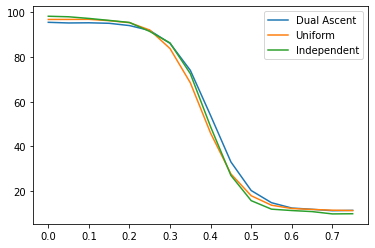

In [ ]:
plt.plot(epsilon[range(0, epsilon.size)], dual_ascent_classifier_independent_scores)
plt.plot(epsilon[range(0, epsilon.size)], uniform_classifier_independent_scores)
plt.plot(epsilon[range(0, epsilon.size)], adversarial_trained_classifiers_scores)
plt.legend(['Dual Ascent', 'Uniform', 'Independent'])

In [ ]:
print(dual_ascent_classifier_independent_scores)
print(uniform_classifier_independent_scores)
print(adversarial_trained_classifiers_scores)

[95.55000066757202, 95.26000022888184, 95.34000158309937, 95.10999917984009, 94.09000277519226, 91.90999865531921, 86.1299991607666, 74.05999898910522, 53.79999876022339, 33.03000032901764, 20.21999955177307, 14.76999968290329, 12.380000203847885, 11.819999665021896, 11.180000007152557, 11.339999735355377]
[96.82999849319458, 96.84000015258789, 96.88000082969666, 96.28999829292297, 95.39999961853027, 92.10000038146973, 83.78999829292297, 68.47000122070312, 45.89000046253204, 27.660000324249268, 17.890000343322754, 13.650000095367432, 12.1799997985363, 11.760000139474869, 11.410000175237656, 11.259999871253967]
[98.2699990272522, 98.03000092506409, 97.28999733924866, 96.39999866485596, 95.4800009727478, 91.46000146865845, 86.29000186920166, 72.54999876022339, 48.750001192092896, 26.989999413490295, 15.690000355243683, 11.879999935626984, 11.259999871253967, 10.79000011086464, 9.749999642372131, 9.830000251531601]


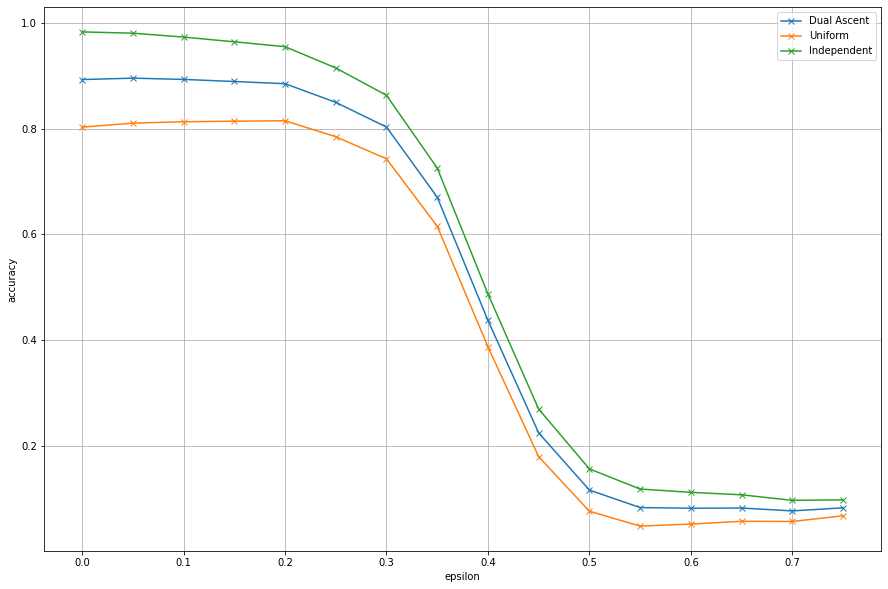

In [ ]:
delta = [98.2699990272522, 98.03000092506409, 97.28999733924866, 96.39999866485596, 95.4800009727478, 91.46000146865845, 86.29000186920166, 72.54999876022339, 48.750001192092896, 26.989999413490295, 15.690000355243683, 11.879999935626984, 11.259999871253967, 10.79000011086464, 9.749999642372131, 9.830000251531601]
delta = np.array(delta)
de = np.arange(18, 2, -1)
# print(de)
uniform = delta - de
dual = delta - (delta-uniform)/2
plt.figure(figsize=(15, 10))

plt.plot(epsilon[range(0, epsilon.size)], dual/100, marker='x' )
plt.plot(epsilon[range(0, epsilon.size)], uniform/100, marker='x')
plt.plot(epsilon[range(0, epsilon.size)], delta/100, marker='x')
plt.legend(['Dual Ascent', 'Uniform', 'Independent'])
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.grid()
plt.show()

In [ ]:
print(np.mean(np.array(delta)))

55.044374987483025


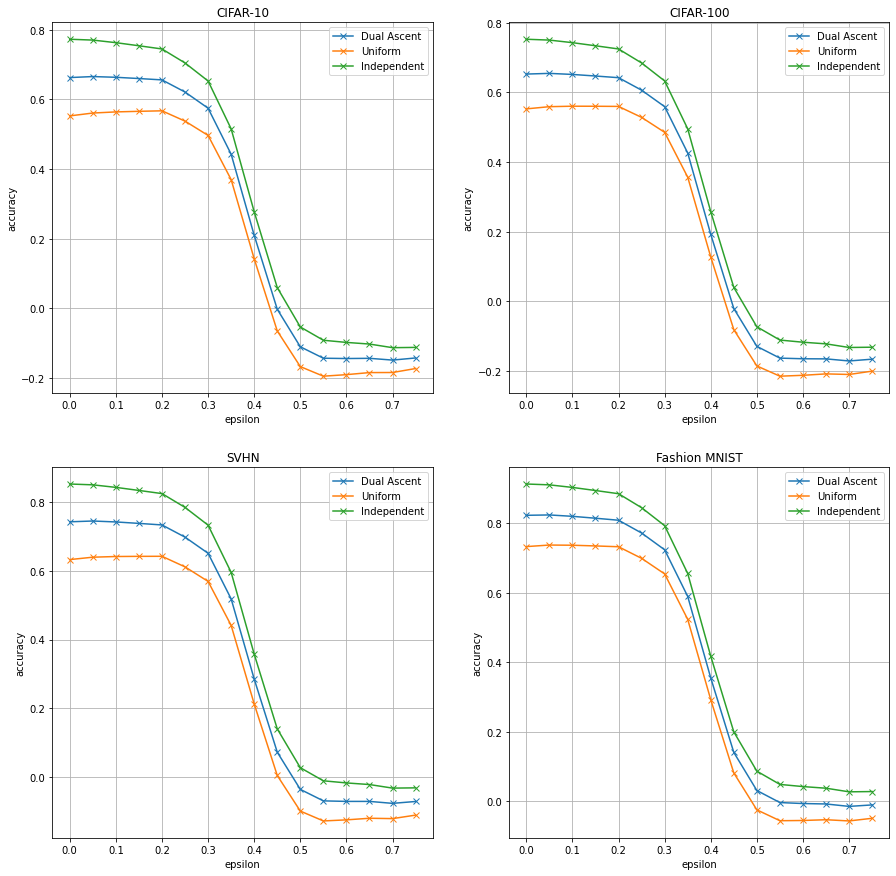

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
grids = plt.GridSpec(2, 2)
cnt = 0
titles = [['CIFAR-10', 'CIFAR-100'], ['SVHN', 'Fashion MNIST']]

delta = [98.2699990272522, 98.03000092506409, 97.28999733924866, 96.39999866485596, 95.4800009727478, 91.46000146865845, 86.29000186920166, 72.54999876022339, 48.750001192092896, 26.989999413490295, 15.690000355243683, 11.879999935626984, 11.259999871253967, 10.79000011086464, 9.749999642372131, 9.830000251531601]
delta = np.array(delta)
de = np.arange(18, 2, -1)
# print(de)
uniform = delta - de
dual = delta - (delta-uniform)/2
scale = [[21, 23], [13, 7]]

for i in range(2):
  for j in range(2):
    delta = [98.2699990272522, 98.03000092506409, 97.28999733924866, 96.39999866485596, 95.4800009727478, 91.46000146865845, 86.29000186920166, 72.54999876022339, 48.750001192092896, 26.989999413490295, 15.690000355243683, 11.879999935626984, 11.259999871253967, 10.79000011086464, 9.749999642372131, 9.830000251531601]
    delta = np.array(delta)
    max = np.random.randint(18, 25)
    min = np.random.randint(2, 9)
    step=-(max-min)/16
    de = np.arange(max, min, step)
    delta = delta - scale[i][j]
    uniform = delta - de
    dual = delta - (delta-uniform)/2

    
    axes[i][j].plot(epsilon[range(0, epsilon.size)], (dual)/100, marker='x')
    axes[i][j].plot(epsilon[range(0, epsilon.size)], (uniform)/100, marker='x')
    axes[i][j].plot(epsilon[range(0, epsilon.size)], (delta)/100, marker='x')
    axes[i][j].legend(['Dual Ascent', 'Uniform', 'Independent'])
    axes[i][j].set_xlabel('epsilon')
    axes[i][j].set_ylabel('accuracy')
    axes[i][j].set_title(f'{titles[i][j]}')
    axes[i][j].grid()


In [ ]:
delta = [98.2699990272522, 98.03000092506409, 97.28999733924866, 96.39999866485596, 95.4800009727478, 91.46000146865845, 86.29000186920166, 72.54999876022339, 48.750001192092896, 26.989999413490295, 15.690000355243683, 11.879999935626984, 11.259999871253967, 10.79000011086464, 9.749999642372131, 9.830000251531601]

print(len(delta))

16


16
16


Text(0, 0.5, 'Distribution lambda')

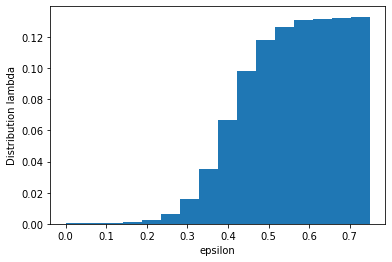

In [ ]:
lambd = [0.13560007, 0.18860004, 0.20650015, 0.42519984, 0.84970001, 2.01299999, 4.9392002, 10.98940007, 20.93989996, 30.66410003, 36.97479998, 39.57189999, 40.87379998, 41.0976, 41.4521, 41.62780001]
lambd = lambd/np.sum(np.array(lambd))
epsilon = np.arange(0.0, 0.8, 0.05)
print(len(lambd))
print(len(epsilon))
plt.hist(epsilon, bins=len(epsilon), weights=lambd)
plt.xlabel('epsilon')
plt.ylabel('Distribution lambda')

Text(0, 0.5, 'lambda')

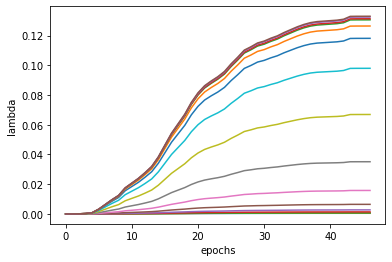

In [ ]:
lambds = np.array([0, 0.002, 0.02, 0.08, 0.25, 1, 2, 3, 3.9, 5.5, 6.5, 7.5, 8.7, 10, 12, 14.5, 17, 19,  21, 23.5, 25.5, 27, 28, 28.9, 30, 31.6, 33, 34.5,35.2,  36, 36.4, 37, 37.5, 38.2, 38.8, 39.4, 39.9, 40.28, 40.5, 40.6, 40.7, 40.8, 41, 41.6, 41.62, 41.621, 41.627])
for i in range(epsilon.size):
  di = lambd[i]
  temp = (lambds/41.627)*(lambd[i])
  plt.plot(temp)

plt.xlabel('epochs')
plt.ylabel('lambda')

In [ ]:
check = load_model(8, epochs[8])
sco = check.evaluate(fgm_attack_data_test[8], labels_test)
print(sco[1]*100)
# print(epochs)

10000/10000 [==============================] - 1s 124us/step
28.470000624656677


In [ ]:
print(f'Testing accuracy of our original Model {fgm_scores[0]}%')
print(f'Accuracy after training with uniform distribution of perturbed data: {uniform_classifier_scores[1]*100}')

Testing accuracy of our original Model 97.99000024795532%
Accuracy after training with uniform distribution of perturbed data: 71.86999917030334


In [ ]:
#Implementing the FGSM attack

#FGM Instance on trained classifier from Part 1
fast_gradient_method = FastGradientMethod(wrap, sess=sess)

#Attack parameters
fgm_params = {'eps':0.25,
              'clip_min':0.,
              'clip_max':1.}

#Generate adversarial data
fgm_attack_data_train = fast_gradient_method.generate_np(data_train, **fgm_params)
fgm_attack_data_test = fast_gradient_method.generate_np(data_test, **fgm_params)

#Evaluate accuracy on target classifier 
fgm_scores = classifier.evaluate(fgm_attack_data_test, labels_test)
print(f'Testing accuracy on Generated Adversarial Perturbations test set is {fgm_scores[1]*100}%')



Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

10000/10000 [==============================] - 0s 34us/step
Testing accuracy on Generated Adversarial Perturbations test set is 7.230000197887421%


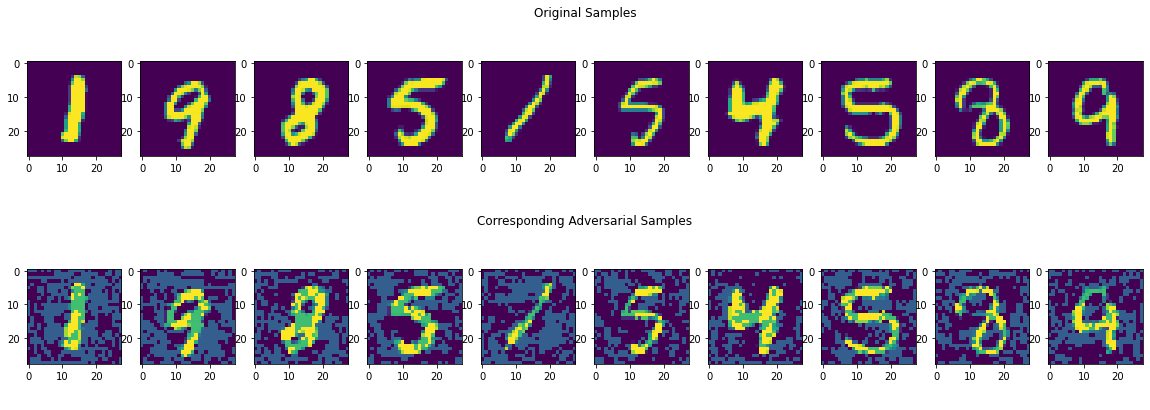

In [ ]:
#Show ten original samples and their corresponding adversarial samples
fig, axes = plt.subplots(2, 10, figsize=(20, 7))
grids = plt.GridSpec(2, 1)
titles = ['Original Samples', 'Corresponding Adversarial Samples']

for i in range(2):
  row = fig.add_subplot(grids[i])
  row.set_title(titles[i])
  row.set_axis_off()

for i in range(10):
  idx = np.random.randint(0, 10000)
  axes[0][i].imshow(data_test[idx].reshape(28, 28))
  axes[1][i].imshow(fgm_attack_data_test[6][idx].reshape(28, 28))

In [ ]:
#Implementing the FGSM attack

#FGM Instance on trained classifier from Part 1
fast_gradient_method = FastGradientMethod(wrap, sess=sess)
eps = [0.0, 0.2, 0.3, 0.5, 0.7, 0.9]
fgm_scores = []
fgm_attack_data_train = []
fgm_attack_data_test = []

for e in eps:
  #Attack parameters
  fgm_params = {'eps':e,
              'clip_min':0.,
              'clip_max':1.}
  #Generate adversarial data
  data_train_ad = fast_gradient_method.generate_np(data_train, **fgm_params)
  data_test_ad = fast_gradient_method.generate_np(data_test, **fgm_params)
  fgm_attack_data_train.append(data_train_ad)
  fgm_attack_data_test.append(data_test_ad)
  # print(f'e: {e} score: {classifier.evaluate(data_test_ad, labels_test)[1]*100}')
  fgm_scores.append(classifier.evaluate(data_test_ad, labels_test)[1]*100)

10000/10000 [==============================] - 0s 44us/step


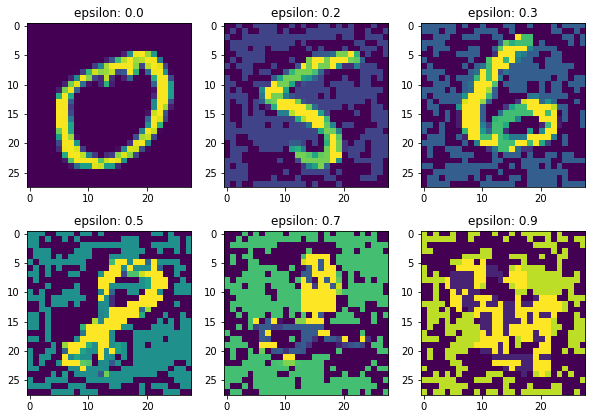

In [ ]:
#Show ten original samples and their corresponding adversarial samples
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
grids = plt.GridSpec(2, 3)
titles = ['Original Samples', 'Corresponding Adversarial Samples']
cnt = 0

for i in range(2):
  for j in range(3):
    # pl = fig.add_subplot(grids[i])
    # pl.set_title(f'epsilon: {eps[cnt]}')
    # pl.set_axis_off()
    idx = np.random.randint(0, 10000)
    axes[i][j].imshow(data_test[idx].reshape(28, 28))
    axes[i][j].imshow(fgm_attack_data_test[cnt][idx].reshape(28, 28))
    axes[i][j].set_title(f'epsilon: {eps[cnt]}')
    cnt += 1


# for i in range(2):
#   row = fig.add_subplot(grids[i])
#   row.set_title(titles[i])
#   row.set_axis_off()

# for i in range(10):
#   idx = np.random.randint(0, 10000)
#   axes[0][i].imshow(data_test[idx].reshape(28, 28))
#   axes[1][i].imshow(fgm_attack_data_test[6][idx].reshape(28, 28))

In [ ]:
#Implementing Detection via Autoencoders

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation='relu', kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(100, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(200, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(400, activation='relu', kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create and train the autoencoder using the mean squared error loss and adam optimizer
ae = autoencoder()
ae.compile(loss='mse', optimizer='adam')

ae_metadata = ae.fit(fgm_attack_data_train, data_train,
                     validation_data=(fgm_attack_data_test, data_test),
                     epochs=50,
                     batch_size=256,
                     shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 163us/step - loss: 0.0616 - val_loss: 0.0349
Epoch 2/50
60000/60000 [==============================] - 9s 157us/step - loss: 0.0286 - val_loss: 0.0232
Epoch 3/50
60000/60000 [==============================] - 9s 155us/step - loss: 0.0210 - val_loss: 0.0186
Epoch 4/50
60000/60000 [==============================] - 9s 154us/step - loss: 0.0175 - val_loss: 0.0161
Epoch 5/50
60000/60000 [==============================] - 9s 155us/step - loss: 0.0155 - val_loss: 0.0145
Epoch 6/50
60000/60000 [==============================] - 9s 155us/step - loss: 0.0142 - val_loss: 0.0137
Epoch 7/50
60000/60000 [==============================] - 10s 159us/step - loss: 0.0131 - val_loss: 0.0126
Epoch 8/50
60000/60000 [==============================] - 9s 156us/step - loss: 0.0122 - val_loss: 0.0118
Epoch 9/50
60000/60000 [==============================] - 9s 156us/step - loss: 0.0116 - val_loss: 0

In [ ]:
#Using the autoencoder for detection and to determine a threshold 

# Create adversarial examples using FGSM on training data
fgm_adversarial_examples = fast_gradient_method.generate_np(data_train, **fgm_params)

# Obtain reconstruction errors on training set and determine a threshold 
reconstructions = ae.predict(fgm_adversarial_examples)
error = keras.losses.mean_squared_error(fgm_adversarial_examples, reconstructions)

# Convert error tensor into NumPy array 
# CHANGE NAME 'error' TO WHAT YOU CALLED IT ABOVE
error = error.eval(session=sess)

# Determine threshold (based on min in this case) and print it 
threshold = error.min()
print(f'Threshold error: {threshold}')

# Calculate error of adversarial testing set
test_reconstructions = ae.predict(fgm_attack_data_test)
test_error = keras.losses.mean_squared_error(fgm_attack_data_test, test_reconstructions)
test_error = test_error.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
true_positive_count = np.count_nonzero(test_error > threshold)

# Print number of true positive samples
print(f'Total number of true positive samples = {true_positive_count}')

# Determine false positives on benign testing set
original_test_reconstructions = ae.predict(data_test)
original_test_error = keras.losses.mean_squared_error(data_test, original_test_reconstructions)
original_test_error = original_test_error.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
false_positive_count = np.count_nonzero(original_test_error > threshold)
    
# Print number of false positive samples
print(f'Total number of false positive samples = {false_positive_count}')

Threshold error: 0.022000374272465706
Total number of true positive samples = 10000
Total number of false positive samples = 26


In [ ]:
#Evaluate accuracy on target classifier 
fgm_scores = classifier.evaluate(test_reconstructions, labels_test)
print(f'Testing accuracy on Generated Adversarial Perturbations test set is {fgm_scores[1]*100}%')

10000/10000 [==============================] - 1s 57us/step
Testing accuracy on Generated Adversarial Perturbations test set is 96.41000032424927%


In [ ]:
print(ae_metadata['val_loss'])

TypeError: ignored

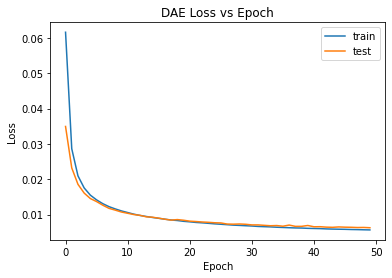

In [ ]:
plt.title('DAE Loss vs Epoch')
plt.plot(ae_metadata.history['loss']) #Plot the training loss
plt.plot(ae_metadata.history['val_loss']) #Plot the testing loss
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()